# Import Libraries

In [21]:
# import jupyterthemes as jt
# !jt -t onedork

In [9]:
# !pip install albumentations --user
# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

  Using cached albumentations-1.3.1-py3-none-any.whl.metadata (34 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-1.3.1-py3-none-any.whl (125 kB)
Using cached opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl (38.5 MB)


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

C:\Users\User\AppData\Local\Temp\ipykernel_12632\3911133755.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


cuda


# Preprocessing

In [2]:
# test_dir = "E:/NIA/5all_data/disease/demo/test/"
# train_dir = "E:/NIA/5all_data/disease/demo/train"
# val_dir = "E:/NIA/5all_data/disease/demo/val"

IMAGE_PATH = 'C:/Users/User/Downloads/Documents/Thesis/bloodcells/new_train_data/images'
MASK_PATH = 'C:/Users/User/Downloads/Documents/Thesis/bloodcells/new_train_data/masks'

In [6]:
print('Train Size   : ', len(train_x))
print('Test Size     : ', len(test_x))
print('Validation size   :', len(val_x))

Train Size   :  3000
Test Size     :  402
Validation size   : 440


## Create TensorDataset

In [7]:
# change np array to tensors
tensor_train_x = torch.Tensor(train_x).permute(0, 3, 1, 2)
tensor_train_y = torch.Tensor(train_y).permute(0, 3, 1, 2)
tensor_test_x = torch.Tensor(test_x).permute(0, 3, 1, 2)
tensor_test_y = torch.Tensor(test_y).permute(0, 3, 1, 2)
tensor_val_x = torch.Tensor(val_x).permute(0, 3, 1, 2)
tensor_val_y = torch.Tensor(val_y).permute(0, 3, 1, 2)

# tensor_train_x = torch.as_tensor(train_x).permute(0, 3, 1, 2)
# tensor_train_y = torch.Tensor(train_y).permute(0, 3, 1, 2)
# tensor_test_x = torch.Tensor(test_x).permute(0, 3, 1, 2)
# tensor_test_y = torch.Tensor(test_y).permute(0, 3, 1, 2)
# tensor_val_x = torch.Tensor(val_x).permute(0, 3, 1, 2)
# tensor_val_y = torch.Tensor(val_y).permute(0, 3, 1, 2)


print(tensor_test_x.shape)
print(tensor_test_y.shape)
print(tensor_val_y.shape)
print(tensor_val_x.shape)

torch.Size([237, 3, 448, 448])
torch.Size([237, 10, 448, 448])
torch.Size([1200, 10, 448, 448])
torch.Size([1200, 3, 448, 448])


In [8]:
n_classes = 9

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  710


In [14]:
n_classes = 9

def create_dfmask():
    name = []
    for dirname, _, filenames in os.walk(MASK_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

dfmask = create_dfmask()
print('Total Images: ', len(dfmask))

Total Images:  710


In [112]:
print(dfmask['id'][11])

001_00106_03


In [99]:
#split data
# X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(df['id'].values, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
# print('Test Size    : ', len(X_test))

Train Size   :  2835
Val Size     :  501


In [15]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + dfmask['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.8)
plt.title('Picture with Mask Appplied')
plt.show()

# list_msks = glob.glob(path)
# mask_img = Image.open(list_maks[90])
# np_sample = np.array(mask_img)

NameError: name 'IMAGE_PATH' is not defined

# Data check

In [8]:
# Custom tensor dataset
class Datasetcheck(Dataset):
    """TensorDataset with support of transforms"""
    def __init__(self, x, y, transform=None):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        
        img = self.x[index]
        mask = self.y[index]
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
                    
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [9]:
t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = Datasetcheck(train_x, train_y, t_test)

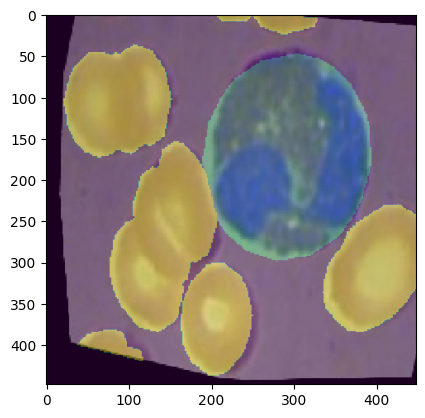

In [29]:
img, mask = test_set[2999]
mask = torch.argmax(mask, dim=2)
plt.imshow(img)

plt.imshow(mask, alpha=0.4)

In [30]:
img, mask = test_set[110]
mask = torch.argmax(mask, dim=2)
# plt.imshow(img)

# plt.imshow(mask, alpha=0.8)

In [40]:
3 in mask.cpu().numpy()

True

# Dataset

In [10]:
# Custom tensor dataset
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms"""
    def __init__(self, x, y, mean, std, transform=None):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.x = x
        self.y = y
        self.mean = mean
        self.std = std
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        
        img = self.x[index]
        mask = self.y[index]
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])       
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
from torch.utils.data.distributed import DistributedSampler

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),  
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.GridDistortion(p=0.2)])
t_test = A.Compose([A.Resize(256, 256,interpolation=cv2.INTER_NEAREST)])

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'

# torch.distributed.init_process_group('gloo',world_size=1,rank=0)



# #datasets
# train_set = OralDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
# val_set = OralDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# Datasets
# train_set = TensorDataset(tensor_train_x, tensor_train_y, )
# val_set = TensorDataset(tensor_test_x, tensor_test_y)

# Custom Dataset
train_set = CustomTensorDataset(train_x, train_y, mean, std, t_train)
val_set = CustomTensorDataset(val_x, val_y, mean, std, t_val) 
test_set_a = CustomTensorDataset(test_x, test_y, mean, std, t_test) 

#dataloader
batch_size= 4

# train_sampler = DistributedSampler(dataset=train_set, shuffle=True)                                                  
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                             sampler=train_sampler, num_workers=10, pin_memory=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=False)

# val_sampler = DistributedSampler(dataset=val_set, shuffle=True)   
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, pin_memory=False)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [54]:
# train_set[0][0].shape
val_set[0][0].shape

torch.Size([3, 256, 256])

# Model

In [55]:
# torch.distributed.init_process_group('gloo',world_size=1,rank=0)

In [11]:
model = smp.Unet('timm-efficientnet-b8', encoder_weights='imagenet', classes=10, activation=None)
#  encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]

In [12]:
import segmentation_models_pytorch as smp
dir(smp)

['DeepLabV3',
 'DeepLabV3Plus',
 'FPN',
 'Linknet',
 'MAnet',
 'PAN',
 'PSPNet',
 'Unet',
 'UnetPlusPlus',
 '_Optional',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_torch',
 'base',
 'create_model',
 'datasets',
 'decoders',
 'encoders',
 'losses',
 'metrics']

In [13]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
          (bn1): BatchNormAct2d(
            72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
# get number of parameters
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 88,124,696 trainable parameters


# Training

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [18]:
import torch.distributed as dist
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)
#     model= nn.DataParallel(model,device_ids = [0, 1, 2, 3])

#     torch.distributed.init_process_group(backend='nccl')
#     dist.init_process_group("gloo", rank=0, world_size=0)
#     model = nn.parallel.DistributedDataParallel(model, device_ids=[0,1,2,3])

    model.to(torch.device('cuda'))
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(torch.device('cuda')); mask = mask_tiles.to(torch.device('cuda'));
#             print(image.shape)
            # remove the channel dimension from target
            mask = torch.argmax(mask, dim=3)
#             print(mask.shape)
            #forward
#             print(image.shape)
            output = model(image)
#             print(output.shape)
#             print(mask.shape)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(torch.device('cuda')); mask = mask_tiles.to(torch.device('cuda'));
                    mask = torch.argmax(mask, dim=3)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
#                 not_improve = 0
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                print('saving best model...')
#                 torch.save(model.state_dict(), 'Best_Disease_TimLite4_upd224ated_data2_v5.pt')
                torch.save(model.state_dict(), 'Best_blood_cell_UNET_weight.pt') 
            elif (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
#                 min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [23]:
# torch.distributed.is_gloo_available()

True

In [19]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

#class weights for 6 class multi-class classification
# class_weights = torch.Tensor([0.70, 0.6949, 0.9003, 0.9444, 0.4901, 0.7399, 0.9801, 0.7079, 0.8342, 0.9782])
# class_weights = torch.Tensor([1, 70, 69, 90, 94, 49, 73, 98, 70, 83, 97])

# class_weights=class_weights.to(torch.device('cuda:2'))
 
#loss function with class weights
# criterion = nn.CrossEntropyLoss(weight = class_weights) 

# criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss()

# nSamples = [8702, 2655, 867, 484, 4437, 2263, 174, 2541, 1443, 190]
# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
# normedWeights = torch.FloatTensor(normedWeights).to(torch.device('cuda:2'))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                           steps_per_epoch=len(train_loader))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler)

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.657 
saving best model...
Epoch:1/50.. Train Loss: 1.301.. Val Loss: 0.657.. Train mIoU:0.224.. Val mIoU: 0.322.. Train Acc:0.594.. Val Acc:0.798.. Time: 4.07m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.657 >> 0.466 
saving best model...
Epoch:2/50.. Train Loss: 0.674.. Val Loss: 0.466.. Train mIoU:0.303.. Val mIoU: 0.382.. Train Acc:0.757.. Val Acc:0.827.. Time: 3.91m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.466 >> 0.385 
saving best model...
Epoch:3/50.. Train Loss: 0.565.. Val Loss: 0.385.. Train mIoU:0.344.. Val mIoU: 0.435.. Train Acc:0.779.. Val Acc:0.853.. Time: 3.91m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.385 >> 0.379 
saving best model...
Epoch:4/50.. Train Loss: 0.517.. Val Loss: 0.379.. Train mIoU:0.382.. Val mIoU: 0.434.. Train Acc:0.792.. Val Acc:0.852.. Time: 4.16m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.379 >> 0.342 
saving best model...
Epoch:5/50.. Train Loss: 0.476.. Val Loss: 0.342.. Train mIoU:0.437.. Val mIoU: 0.527.. Train Acc:0.809.. Val Acc:0.872.. Time: 3.90m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/50.. Train Loss: 0.456.. Val Loss: 0.477.. Train mIoU:0.487.. Val mIoU: 0.569.. Train Acc:0.815.. Val Acc:0.857.. Time: 4.01m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.342 >> 0.315 
saving best model...
Epoch:7/50.. Train Loss: 0.431.. Val Loss: 0.315.. Train mIoU:0.549.. Val mIoU: 0.629.. Train Acc:0.827.. Val Acc:0.888.. Time: 4.03m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/50.. Train Loss: 0.419.. Val Loss: 0.343.. Train mIoU:0.573.. Val mIoU: 0.596.. Train Acc:0.833.. Val Acc:0.877.. Time: 3.97m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Decreasing.. 0.315 >> 0.286 
saving best model...
Epoch:9/50.. Train Loss: 0.405.. Val Loss: 0.286.. Train mIoU:0.597.. Val mIoU: 0.705.. Train Acc:0.835.. Val Acc:0.891.. Time: 3.92m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/50.. Train Loss: 0.396.. Val Loss: 0.308.. Train mIoU:0.617.. Val mIoU: 0.655.. Train Acc:0.838.. Val Acc:0.885.. Time: 4.04m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:11/50.. Train Loss: 0.372.. Val Loss: 0.342.. Train mIoU:0.632.. Val mIoU: 0.705.. Train Acc:0.847.. Val Acc:0.894.. Time: 4.16m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:12/50.. Train Loss: 0.373.. Val Loss: 0.408.. Train mIoU:0.638.. Val mIoU: 0.660.. Train Acc:0.845.. Val Acc:0.874.. Time: 3.99m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:13/50.. Train Loss: 0.371.. Val Loss: 0.319.. Train mIoU:0.651.. Val mIoU: 0.702.. Train Acc:0.847.. Val Acc:0.892.. Time: 4.03m


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 56.03 m


In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

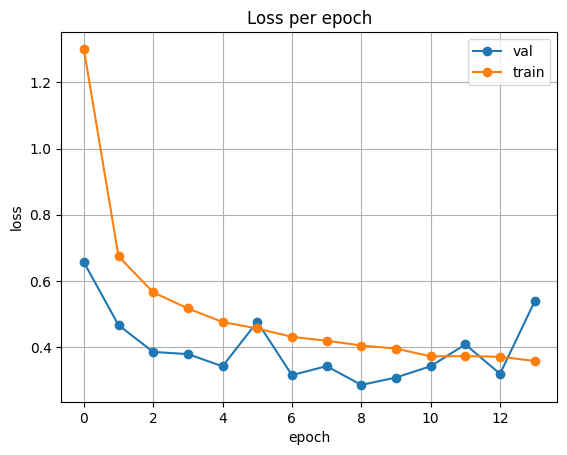

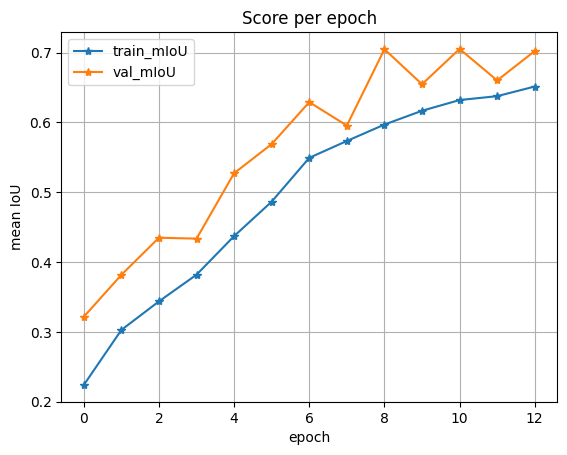

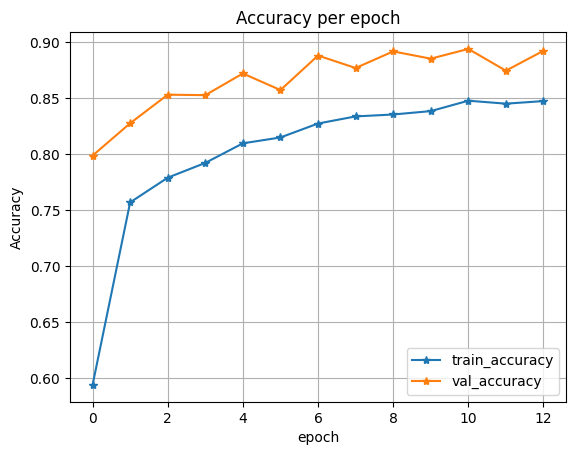

In [21]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [22]:
# Load the saved model
model.load_state_dict(torch.load('Best_blood_cell_UNET_weight.pt'))
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
          (bn1): BatchNormAct2d(
            72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False

In [23]:
# Custom tensor dataset
class CustomTestDataset(Dataset):
    """TensorDataset with support of transforms"""
    def __init__(self, x, y, transform=None):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        
        img = self.x[index]
        mask = self.y[index]
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
                    
        mask = torch.from_numpy(mask).long()
        
        return img, mask



In [24]:
t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = CustomTestDataset(test_x, test_y, t_test)
# test_set = TensorDataset(tensor_test_x, tensor_test_y)
# train_set = CustomTestDataset(train_x, train_y, t_test)

## Result

In [25]:
def mIoU_modified(pred_mask, mask, smooth=1e-10, n_classes=10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                
                iou_no= intersect / union
                

                iou = (intersect + smooth) / (union +smooth)
                
                iou_per_class.append(iou)
#             print(intersect)
#             print(union)
#             print(iou)
#             print(iou_no)
#             print(iou_per_class)
        return np.nanmean(iou_per_class)

In [4]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [5]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        mask = torch.argmax(mask, dim=3)
        
        output = model(image)
#         print(image.shape)
#         print(mask.shape)
#         print(output.shape)
#         score = mIoU(output, mask)
        score =  mIoU_modified(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [6]:
def predict_image_mask_miou_allmetrics(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        mask_recall = mask.permute(0, 3, 1, 2)
        mask = torch.argmax(mask, dim=3)
        
        output = model(image)
#         print(output.shape)
#         print(mask.shape)
#         score = mIoU(output, mask)
        score = mIoU_modified(output, mask)
        
        # calculate recall
        tp, fp, fn, tn = smp.metrics.get_stats(output, mask_recall, mode='multilabel', threshold=0.5)
#         print(tp)
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
#         print(recall)
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, recall, precision, f1_score

In [29]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        mask = torch.argmax(mask, dim=3)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=3)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [30]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [9]:
def miou_score_allmetrics(model, test_set):
    score_iou = []
    score_recall = []
    score_precision = []
    score_f1 = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score, recall, precision, f1_score = predict_image_mask_miou_allmetrics(model, img, mask)
        
        score_iou.append(score)
        score_recall.append(recall.detach().cpu().numpy())
        score_precision.append(precision.detach().cpu().numpy())
        score_f1.append(f1_score.detach().cpu().numpy())
        
    return score_iou, score_recall, score_precision, score_f1

In [14]:
mob_miou, score_recall, score_precision, score_f1 = miou_score_allmetrics(model, test_set)

NameError: name 'test_set' is not defined

In [38]:
mob_miou, score_recall, score_precision, score_f1 = miou_score_allmetrics(model, test_set)

  0%|          | 0/2608 [00:00<?, ?it/s]

In [33]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [34]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/402 [00:00<?, ?it/s]

In [7]:
print('mIoU', np.mean(mob_miou),
      '\nPrecision', np.mean(score_precision),
      '\nRecall', np.mean(score_recall),
      '\nF1_Score', np.mean(score_f1),
      '\nPixel Accuracy', np.mean(mob_acc))

NameError: name 'mob_miou' is not defined

In [43]:
print('mIoU_with background', np.mean(mob_miou),
      '\nPrecision', np.mean(score_precision),
      '\nRecall', np.mean(score_recall),
      '\nF1_Score', np.mean(score_f1),
      '\nPixel Accuracy', np.mean(mob_acc))

mIoU_with background 0.6033116476834094 
Precision 0.9679887 
Recall 0.8166343 
F1_Score 0.88396394 
Pixel Accuracy 0.980926930150655


In [65]:
pred_mask.cpu().numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

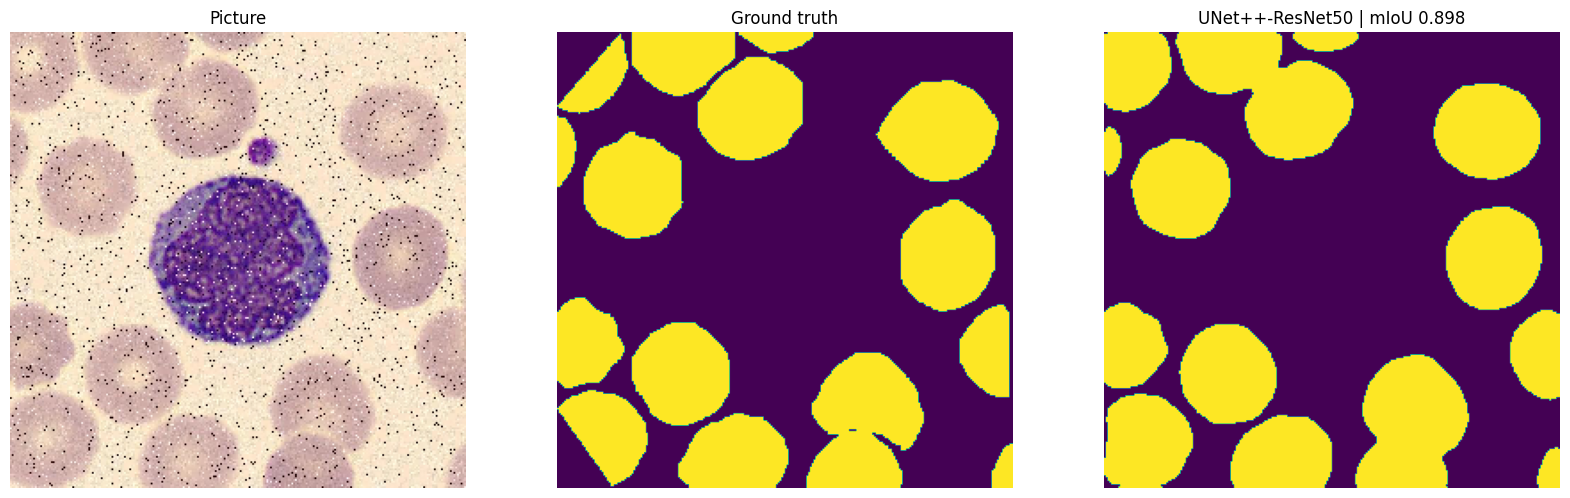

In [40]:
image2, mask2 = test_set[1]

pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
# ax1.imshow(image2.permute(1, 2, 0).numpy().astype('uint8'))
ax1.imshow(image2)
ax1.set_title('Picture');
ax1.set_axis_off()

mask2 = torch.argmax(mask2, dim=2)
ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet++-ResNet50 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()